In [ ]:
from google.colab import drive

drive.mount('/content/drive')

!cp -r drive/MyDrive/Projetift870/fruits/* .

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

chargement des données

In [ ]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
"images",
    shuffle=True
)

Found 10762 files belonging to 10 classes.


In [ ]:
#visualisation des nombres de classes
class_names=dataset.class_names
class_names

['apple',
 'avocado',
 'banana',
 'black berry',
 'blueberry',
 'corn kernel',
 'mandarine',
 'mango',
 'pineapple',
 'strawberry']

CREATION DES DONNEES (TRAIN AND TEST)

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

données d'entrainement

In [ ]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  "images",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10762 files belonging to 10 classes.
Using 8610 files for training.


données de test

In [ ]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  "images",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10762 files belonging to 10 classes.
Using 2152 files for validation.


In [ ]:
#visualisation de l'ensemble des classes qui existent dans les donnes d'entrainement
class_names=train_dataset.class_names
print(class_names)

['apple', 'avocado', 'banana', 'black berry', 'blueberry', 'corn kernel', 'mandarine', 'mango', 'pineapple', 'strawberry']


VISUALISATION DES DONNEES D'ENTRAITEMENT 

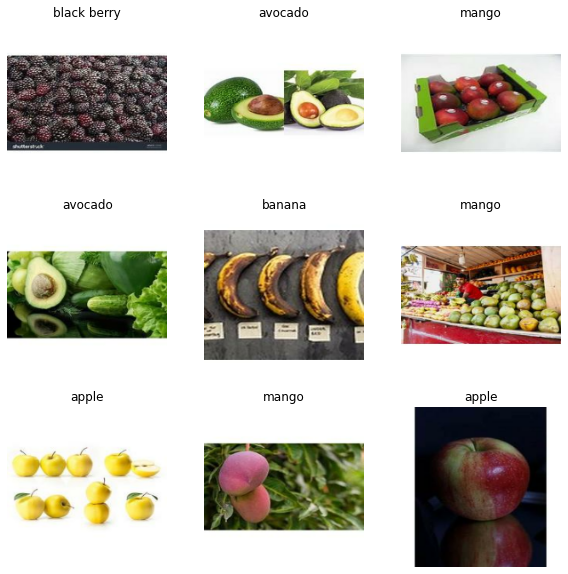

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
# on peut aussi récuperer les lots d'images dans nos donneés 
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


il s'agit de lot de 32 images de la forme 180**180*32 avec un RVB égale à 32




CONFIGURATION DES DONNEES POUR LA PERFORMANCE

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) 
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Standardisation des données

In [ ]:
#nous allons normaliser la valeurs du RVB dans l'interval [0,1]
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_dataset))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


nous venons de normaliser les valeurs des canneaux entre 0 et 1 car nous devons avoir des entrées petites

CREATION DE NOTRE MODELE

nous allosn créer notre modèle avec 3 couches de convolutions conv2D, MAxpoling 

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
#compilation de notre modèle 
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
#affichage des couhes de notre modèle 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

entrainement de notre modèle avec les données d'entraitement

In [ ]:
epochs=5
history = model.fit(
  train_dataset,
  validation_data=train_dataset,
  epochs=epochs
)

Epoch 1/5
270/270 [==============================] - 238s 882ms/step - loss: 0.6976 - accuracy: 0.7661 - val_loss: 0.8181 - val_accuracy: 0.7305
Epoch 2/5
270/270 [==============================] - 237s 879ms/step - loss: 0.5201 - accuracy: 0.8250 - val_loss: 0.9865 - val_accuracy: 0.6989
Epoch 3/5
270/270 [==============================] - 238s 880ms/step - loss: 0.3885 - accuracy: 0.8669 - val_loss: 0.9480 - val_accuracy: 0.7398
Epoch 4/5
270/270 [==============================] - 238s 880ms/step - loss: 0.2551 - accuracy: 0.9160 - val_loss: 0.9752 - val_accuracy: 0.7388
Epoch 5/5
270/270 [==============================] - 237s 880ms/step - loss: 0.1753 - accuracy: 0.9430 - val_loss: 1.2254 - val_accuracy: 0.7063


VISUALISATION DES RESULTATS D'ENTRAITEMENT 

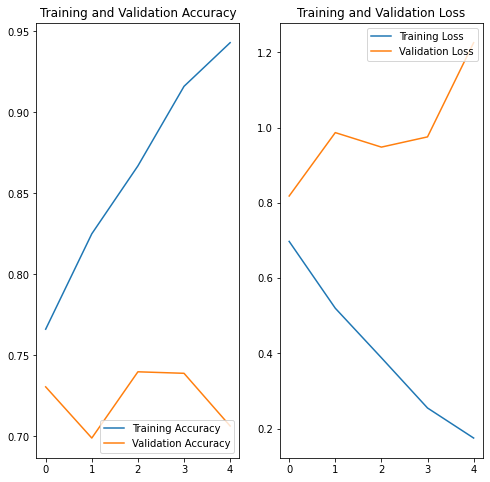

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

entrainement de notre modèle avec les données de test

In [ ]:
epochs=5
history = model.fit(
  test_dataset,
  validation_data=test_dataset,
  epochs=epochs
)

Epoch 1/5
68/68 [==============================] - 72s 1s/step - loss: 0.8674 - accuracy: 0.7240 - val_loss: 0.5004 - val_accuracy: 0.8313
Epoch 2/5
68/68 [==============================] - 71s 1s/step - loss: 0.4685 - accuracy: 0.8420 - val_loss: 0.3128 - val_accuracy: 0.8992
Epoch 3/5
68/68 [==============================] - 71s 1s/step - loss: 0.3058 - accuracy: 0.8941 - val_loss: 0.2432 - val_accuracy: 0.9229
Epoch 4/5
68/68 [==============================] - 71s 1s/step - loss: 0.2050 - accuracy: 0.9308 - val_loss: 0.1225 - val_accuracy: 0.9679
Epoch 5/5
68/68 [==============================] - 71s 1s/step - loss: 0.1302 - accuracy: 0.9568 - val_loss: 0.0645 - val_accuracy: 0.9879


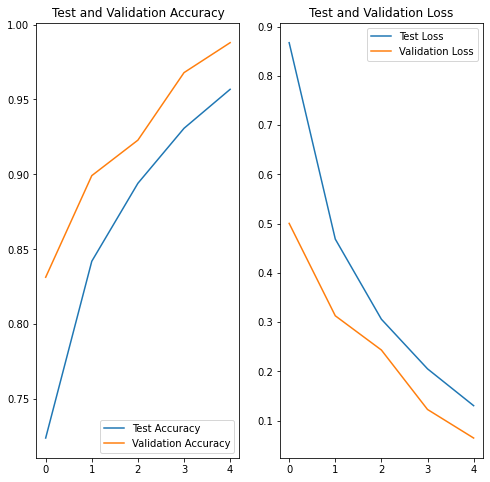

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Test Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Test and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Test Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Test and Validation Loss')
plt.show()